In [2]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from segment_anything import sam_model_registry

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



cuda


In [3]:
print(f"Memory Allocated: {torch.cuda.memory_allocated(device)/1024**2} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved(device)/1024**2} MB")


Memory Allocated: 0.0 MB
Memory Reserved: 0.0 MB


In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        # Extract the base filenames without extensions
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))

        # Create a dictionary mapping from image base names to mask filenames
        self.image_to_mask_map = {}
        for image_name in self.image_filenames:
            image_base_name = os.path.splitext(image_name)[0]
            corresponding_mask = None
            
            for mask_name in self.mask_filenames:
                if image_base_name in mask_name:
                    corresponding_mask = mask_name
                    break
            
            if corresponding_mask:
                self.image_to_mask_map[image_base_name] = corresponding_mask
            else:
                print(f"No corresponding mask found for image: {image_name}")
        
        print(f"Number of valid pairs: {len(self.image_to_mask_map)}")
        if len(self.image_to_mask_map) == 0:
            print("Warning: No valid image-mask pairs found!")

    def __len__(self):
        return len(self.image_to_mask_map)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_base_name = os.path.splitext(image_name)[0]
        
        mask_name = self.image_to_mask_map.get(image_base_name)

        if mask_name is None:
            raise ValueError(f"No mask found for image: {image_name}")

        image_path = os.path.join(self.images_dir, image_name)
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return {'image': image, 'label': mask}


images_dir = "./ISIC-2017_Training_Data/"
masks_dir = "./ISIC-2017_Training_Part1_GroundTruth"

transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()  
])

dataset = SegmentationDataset(images_dir, masks_dir, transform=transform)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Dataset size: {len(dataset)}")
sample = dataset[0]
print(f"Sample features: {sample.keys()}")  


Number of valid pairs: 2000
2000
Dataset size: 2000
Sample features: dict_keys(['image', 'label'])


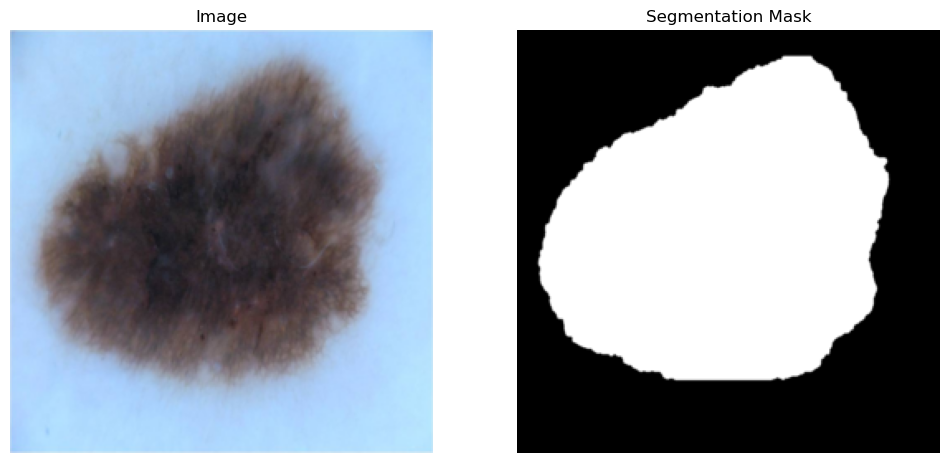

In [5]:
import matplotlib.pyplot as plt

sample = dataset[0]

image = sample['image']
label = sample['label']

image_np = image.permute(1, 2, 0).numpy()  
label_np = label.squeeze().numpy()  

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(label_np, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()


In [6]:
import numpy as np
def get_bounding_box(ground_truth_mask):
    if ground_truth_mask.ndim > 2:
        ground_truth_mask = np.squeeze(ground_truth_mask)
    
    if ground_truth_mask.ndim != 2:
        raise ValueError("Expected a 2D mask after squeezing, but got a different shape.")
    
    y_indices, x_indices = np.where(ground_truth_mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    
    return [x_min, y_min, x_max, y_max]


In [7]:
class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        if ground_truth_mask.ndim > 2:
            ground_truth_mask = np.squeeze(ground_truth_mask)

        prompt = get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs


In [8]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

2024-08-24 18:32:11.730822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 18:32:11.731047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 18:32:11.758568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 18:32:11.821489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 18:32:14.667577: W tensorflow/compiler/tf2

In [9]:
print(f"Memory Allocated: {torch.cuda.memory_allocated(device)/1024**2} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved(device)/1024**2} MB")


Memory Allocated: 0.0 MB
Memory Reserved: 0.0 MB


In [10]:
full_dataset = SAMDataset(dataset=dataset, processor=processor)

In [11]:
example = full_dataset[0]  
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [11]:
# from torch.utils.data import DataLoader
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [12]:
print(f"Memory Allocated: {torch.cuda.memory_allocated(device)/1024**2} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved(device)/1024**2} MB")


Memory Allocated: 0.0 MB
Memory Reserved: 0.0 MB


In [13]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

batch_size = 1  
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 256, 256])


In [15]:
batch["ground_truth_mask"].shape

torch.Size([1, 256, 256])

In [16]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

/home/virendrasinh10/anaconda3/lib/python3.11/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_fi

In [17]:
print(f"Memory Allocated: {torch.cuda.memory_allocated(device)/1024**2} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved(device)/1024**2} MB")


Memory Allocated: 0.0 MB
Memory Reserved: 0.0 MB


In [18]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [19]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 30

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)


cuda


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [20]:
print(f"Memory Allocated: {torch.cuda.memory_allocated(device)/1024**2} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved(device)/1024**2} MB")


Memory Allocated: 357.58544921875 MB
Memory Reserved: 402.0 MB


In [21]:
import torch

def jaccard_index(pred, target):
    intersection = torch.logical_and(pred, target).float().sum()
    union = torch.logical_or(pred, target).float().sum()
    return intersection / union

def evaluate_model(dataloader, model, device):
    model.eval()  
    jaccard_indices = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)

            predicted_masks = (predicted_masks > 0.5).float()

            # Compute the Jaccard Index for each mask in the batch
            for pred_mask, gt_mask in zip(predicted_masks, ground_truth_masks):
                jaccard = jaccard_index(pred_mask, gt_mask)
                jaccard_indices.append(jaccard.item())

    mean_jaccard = torch.tensor(jaccard_indices).mean().item()
    return mean_jaccard


In [22]:
import ipywidgets as widgets
from IPython.display import display
from tqdm.notebook import tqdm  
from statistics import mean  

output_widget = widgets.Output()
display(output_widget)

with output_widget:
    for epoch in range(num_epochs):
        model.train()  
        epoch_losses = []
        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(device)/1024**2} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(device)/1024**2} MB")
        k=0
        for batch in tqdm(train_dataloader):
            k+=1
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            if (k%100==0):
                print(f' running on: {device} Batch {k}: Loss: {loss.item():.4f}')

        print(f'Mean loss: {mean(epoch_losses)}')
        if epoch%9==0:
            torch.save(model,f"./{epoch}.h5")

        val_jaccard = evaluate_model(val_dataloader, model, device)
        print(f"Validation Jaccard Index after epoch {epoch + 1}: {val_jaccard:.4f}")


Output()

In [ ]:
torch.save(model,f"./fine_tuned_sam.h5")

In [22]:
import torch
model=torch.load("./27.h5")

/tmp/ipykernel_471778/3082839779.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load("./27.h5")


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [24]:
import ipywidgets as widgets
from IPython.display import display
from tqdm.notebook import tqdm  
test_jaccard = evaluate_model(test_dataloader, model, device)
print(f"Test Jaccard Index: {test_jaccard:.4f}")


  0%|          | 0/200 [00:00<?, ?it/s]

Test Jaccard Index: 0.8113


In [25]:
print(f"Memory Allocated: {torch.cuda.memory_allocated(device)/1024**2} MB")
print(f"Memory Reserved: {torch.cuda.memory_reserved(device)/1024**2} MB")

Memory Allocated: 723.2958984375 MB
Memory Reserved: 3496.0 MB


In [26]:
import numpy as np
from PIL import Image

idx = 10

image = dataset[idx]["image"]
image

tensor([[[0.3961, 0.2667, 0.2627,  ..., 0.2549, 0.2549, 0.3882],
         [0.1922, 0.0235, 0.0157,  ..., 0.0078, 0.0078, 0.1922],
         [0.1961, 0.0196, 0.0118,  ..., 0.0078, 0.0078, 0.1882],
         ...,
         [0.2157, 0.0431, 0.0392,  ..., 0.0235, 0.0235, 0.1961],
         [0.2118, 0.0471, 0.0392,  ..., 0.0235, 0.0275, 0.1961],
         [0.4078, 0.2784, 0.2745,  ..., 0.2627, 0.2667, 0.3922]],

        [[0.3961, 0.2667, 0.2627,  ..., 0.2549, 0.2549, 0.3882],
         [0.1922, 0.0235, 0.0157,  ..., 0.0078, 0.0078, 0.1922],
         [0.1961, 0.0196, 0.0118,  ..., 0.0078, 0.0078, 0.1882],
         ...,
         [0.2157, 0.0431, 0.0392,  ..., 0.0235, 0.0235, 0.1961],
         [0.2118, 0.0471, 0.0392,  ..., 0.0235, 0.0275, 0.1961],
         [0.4078, 0.2784, 0.2745,  ..., 0.2627, 0.2667, 0.3922]],

        [[0.3961, 0.2667, 0.2627,  ..., 0.2549, 0.2549, 0.3882],
         [0.1922, 0.0235, 0.0157,  ..., 0.0078, 0.0078, 0.1922],
         [0.1961, 0.0196, 0.0118,  ..., 0.0078, 0.0078, 0.

In [27]:
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [28]:
model.eval()

with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [29]:
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

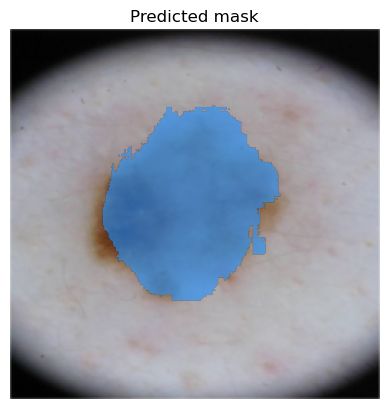

In [35]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

image_transposed = np.transpose(image, (1, 2, 0))

axes.imshow(np.array(image_transposed))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

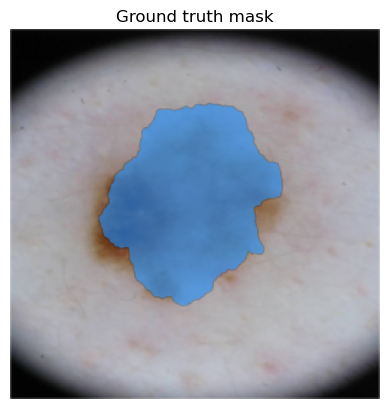

In [37]:
fig, axes = plt.subplots()
image_transposed = np.transpose(image, (1, 2, 0))

axes.imshow(np.array(image_transposed))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")